## Imports

In [1]:
import sys
sys.path.append('../')

In [2]:
from munch import Munch
from PIL import Image
import torch
import numpy as np
import cv2

In [3]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image

In [4]:
from core.data_loader import get_test_loader, InputFetcher, get_test_transform
from core.solver import Solver
from core.model import build_model
from core.utils import denormalize

In [5]:
%load_ext autoreload
%autoreload 2

## Objective

* Create a `predict` function that accepts 1 source image and 1 reference image

## Get shape of data passed to `utils.translate_using_reference`

In [6]:
args = Munch(src_dir='../assets/representative/celeba_hq/src',
            ref_dir='../assets/representative/celeba_hq/ref',
            img_size=256,
            val_batch_size=4,
            num_workers=4,
            latent_dim=16)

In [7]:
loaders = Munch(src=get_test_loader(root=args.src_dir,
                                            img_size=args.img_size,
                                            batch_size=args.val_batch_size,
                                            shuffle=False,
                                            num_workers=args.num_workers),
                        ref=get_test_loader(root=args.ref_dir,
                                            img_size=args.img_size,
                                            batch_size=args.val_batch_size,
                                            shuffle=False,
                                            num_workers=args.num_workers))

Preparing DataLoader for the generation phase...
Preparing DataLoader for the generation phase...


In [8]:
src = next(InputFetcher(loaders.src, None, args.latent_dim, 'test'))
ref = next(InputFetcher(loaders.ref, None, args.latent_dim, 'test'))

In [9]:
src.x.shape

torch.Size([4, 3, 256, 256])

In [10]:
ref.x.shape

torch.Size([4, 3, 256, 256])

In [11]:
ref.y.shape

torch.Size([4])

In [12]:
ref.y

tensor([0, 0, 0, 0], device='cuda:0')

In [13]:
ref.y.type()

'torch.cuda.LongTensor'

## Preparing inputs to `utils.translate_using_reference`

In [14]:
args = Munch({
    'img_size': 256,
    'style_dim': 64,
    'w_hpf': 1.0,
    'latent_dim': 16,
    'num_domains': 2,
    'wing_path': '../expr/checkpoints/wing.ckpt',
    'resume_iter': 100000,
    'checkpoint_dir': '../expr/checkpoints/celeba_hq',
    'mode': 'sample'
})

In [15]:
# use the solver object as it offers some useful methods
solver = Solver(args)

Number of parameters of generator: 43467395
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20916928
Number of parameters of discriminator: 20852290
Number of parameters of fan: 6333603
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...


In [16]:
solver._load_checkpoint(args.resume_iter)

Loading checkpoint from ../expr/checkpoints/celeba_hq/100000_nets_ema.ckpt...


In [17]:
nets = solver.nets_ema

In [18]:
x_src = src.x
x_ref = ref.x
y_ref = ref.y

## Within `utils.translate_using_reference`

In [19]:
N, C, H, W = x_src.size()
wb = torch.ones(1, C, H, W).to(x_src.device)
x_src_with_wb = torch.cat([wb, x_src], dim=0)

In [20]:
masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None
s_ref = nets.style_encoder(x_ref, y_ref)
s_ref_list = s_ref.unsqueeze(1).repeat(1, N, 1)
x_concat = [x_src_with_wb]

/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [21]:
for i, s_ref in enumerate(s_ref_list):
    x_fake = nets.generator(x_src, s_ref, masks=masks)
    x_fake_with_ref = torch.cat([x_ref[i:i+1], x_fake], dim=0)
    x_concat += [x_fake_with_ref]

/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [22]:
x_concat = torch.cat(x_concat, dim=0)

In [23]:
x = denormalize(x_concat)

In [24]:
save_image(x.cpu(), '../test.jpg', nrow=N+1, padding=0)

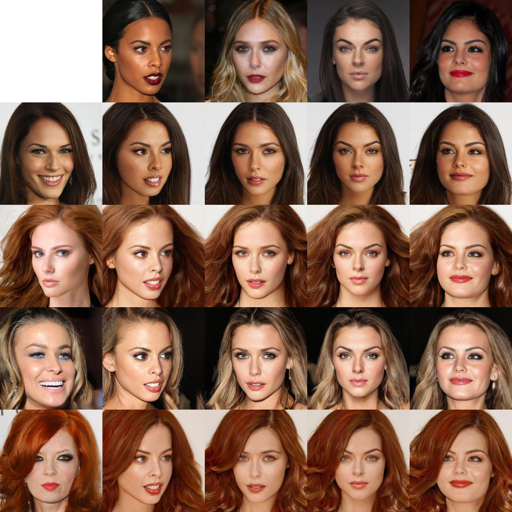

In [25]:
Image.open('../test.jpg').resize((512,512))

## Using only 1 image within `utils.translate_using_reference`

In [26]:
x_src_sample = x_src[:1]
x_ref_sample = x_ref[:1]
y_ref_sample = y_ref[:1]

In [27]:
x_src_sample.shape

torch.Size([1, 3, 256, 256])

In [28]:
masks = nets.fan.get_heatmap(x_src_sample) if args.w_hpf > 0 else None

/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [29]:
s_ref_sample = nets.style_encoder(x_ref_sample, y_ref_sample)

In [30]:
x_fake = nets.generator(x_src_sample, s_ref_sample, masks=masks)

/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [31]:
x_fake.shape

torch.Size([1, 3, 256, 256])

In [32]:
fake_sample = x_fake.squeeze()
fake_sample = denormalize(fake_sample)
fake_sample = fake_sample.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
fake_sample = fake_sample.to('cpu', torch.uint8).numpy()

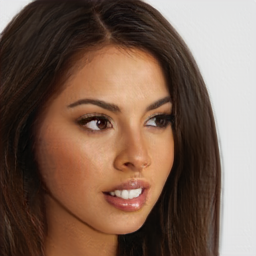

In [33]:
Image.fromarray(fake_sample)

## Performing image translation using 1 source and 1 reference image

In [34]:
source = Image.open('../assets/representative/celeba_hq/src/female/039913.jpg')

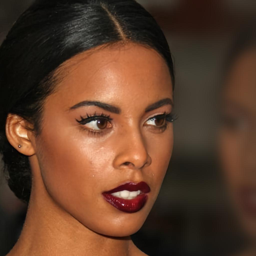

In [35]:
source.resize((256,256))

In [36]:
ref = Image.open('../assets/representative/celeba_hq/ref/female/015248.jpg')

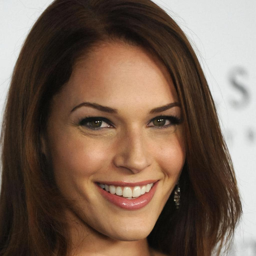

In [37]:
ref.resize((256,256))

In [38]:
transform = get_test_transform(256)

In [39]:
transformed_source = transform(source)
transformed_ref = transform(ref)

In [40]:
transformed_ref.shape

torch.Size([3, 256, 256])

In [41]:
# add one dimen
transformed_source.unsqueeze_(0);
transformed_ref.unsqueeze_(0);

In [42]:
transformed_source.shape

torch.Size([1, 3, 256, 256])

In [43]:
transformed_ref = transformed_ref.cuda()
transformed_source = transformed_source.cuda()

In [44]:
transformed_ref_y = torch.tensor([0]).cuda()

In [45]:
masks = nets.fan.get_heatmap(transformed_source) if args.w_hpf > 0 else None

/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [46]:
s_ref_sample = nets.style_encoder(transformed_ref, transformed_ref_y)

In [47]:
x_fake = nets.generator(transformed_source, s_ref_sample, masks=masks)

/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [48]:
fake_sample = x_fake.squeeze()
fake_sample = denormalize(fake_sample)
fake_sample = fake_sample.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
fake_sample = fake_sample.to('cpu', torch.uint8).numpy()

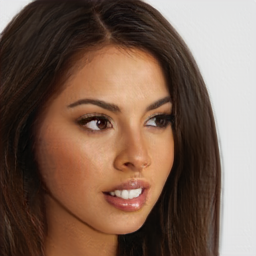

In [49]:
Image.fromarray(fake_sample)

## Refactoring as `predict` function in `Solver`

* Initial experiment below was run using `self._load_checkpoint(args.resume_iter)` in `Solver.predict`
* `self._load_checkpoint(args.resume_iter)` is taken out after confirming that preloading allows faster inference

In [6]:
source = Image.open('../assets/representative/celeba_hq/src/female/039913.jpg')

In [7]:
ref = Image.open('../assets/representative/celeba_hq/ref/female/015248.jpg')

In [8]:
args = Munch({
    'img_size': 256,
    'style_dim': 64,
    'w_hpf': 1.0,
    'latent_dim': 16,
    'num_domains': 2,
    'wing_path': '../expr/checkpoints/wing.ckpt',
    'resume_iter': 100000,
    'checkpoint_dir': '../expr/checkpoints/celeba_hq',
    'mode': 'sample'
})

In [9]:
# use the solver object as it offers some useful methods
solver = Solver(args)

Number of parameters of generator: 43467395
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20916928
Number of parameters of discriminator: 20852290
Number of parameters of fan: 6333603
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...


Loading checkpoint from ../expr/checkpoints/celeba_hq/100000_nets_ema.ckpt...


/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


CPU times: user 394 ms, sys: 91.5 ms, total: 486 ms
Wall time: 451 ms


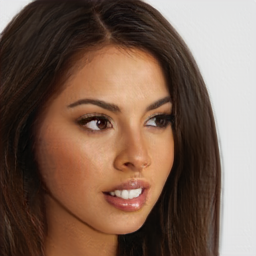

In [10]:
%%time
solver.predict(source, ref, 'female')

### Another example

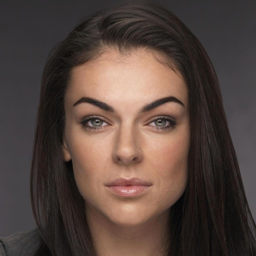

In [11]:
source = Image.open('../assets/representative/celeba_hq/src/female/069067.jpg')
source.resize((256,256))

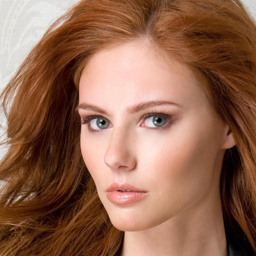

In [12]:
ref = Image.open('../assets/representative/celeba_hq/ref/female/030321.jpg')
ref.resize((256,256))

Loading checkpoint from ../expr/checkpoints/celeba_hq/100000_nets_ema.ckpt...
CPU times: user 220 ms, sys: 57.6 ms, total: 278 ms
Wall time: 244 ms


/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


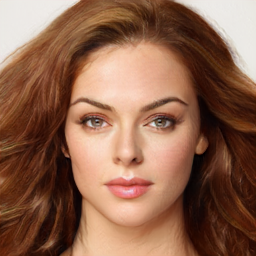

In [13]:
%%time
solver.predict(source, ref, 'female')

### Preloading checkpoint before predict

Code below is runned after removing `self._load_checkpoint(args.resume_iter)` from `Solver.predict`

In [17]:
source = Image.open('../assets/representative/celeba_hq/src/female/039913.jpg')

In [18]:
ref = Image.open('../assets/representative/celeba_hq/ref/female/015248.jpg')

In [8]:
args = Munch({
    'img_size': 256,
    'style_dim': 64,
    'w_hpf': 1.0,
    'latent_dim': 16,
    'num_domains': 2,
    'wing_path': '../expr/checkpoints/wing.ckpt',
    'resume_iter': 100000,
    'checkpoint_dir': '../expr/checkpoints/celeba_hq',
    'mode': 'sample'
})

In [9]:
# use the solver object as it offers some useful methods
solver = Solver(args)

Number of parameters of generator: 43467395
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20916928
Number of parameters of discriminator: 20852290
Number of parameters of fan: 6333603
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...


In [10]:
%%time
solver._load_checkpoint(args.resume_iter)

Loading checkpoint from ../expr/checkpoints/celeba_hq/100000_nets_ema.ckpt...
CPU times: user 139 ms, sys: 71.6 ms, total: 211 ms
Wall time: 228 ms


/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


CPU times: user 327 ms, sys: 5.09 ms, total: 333 ms
Wall time: 289 ms


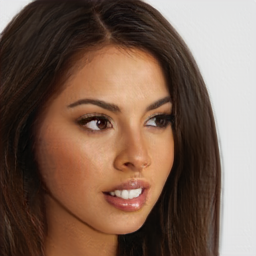

In [11]:
%%time
solver.predict(source, ref, 'female')

In [20]:
source = Image.open('../assets/representative/celeba_hq/src/female/069067.jpg')
ref = Image.open('../assets/representative/celeba_hq/ref/female/030321.jpg')

CPU times: user 119 ms, sys: 0 ns, total: 119 ms
Wall time: 82.9 ms


/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


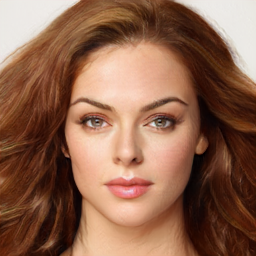

In [21]:
%%time
solver.predict(source, ref, 'female')

__As expected, preloading checkpoint makes inference much faster__

### Proper Usage

In [6]:
source = Image.open('../assets/representative/celeba_hq/src/female/039913.jpg')

In [7]:
ref = Image.open('../assets/representative/celeba_hq/ref/female/015248.jpg')

In [8]:
args = Munch({
    'img_size': 256,
    'style_dim': 64,
    'w_hpf': 1.0,
    'latent_dim': 16,
    'num_domains': 2,
    'wing_path': '../expr/checkpoints/wing.ckpt',
    'resume_iter': 100000,
    'checkpoint_dir': '../expr/checkpoints/celeba_hq',
    'mode': 'sample'
})

In [9]:
# use the solver object as it offers some useful methods
solver = Solver(args)

Number of parameters of generator: 43467395
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20916928
Number of parameters of discriminator: 20852290
Number of parameters of fan: 6333603
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...


In [10]:
solver._load_checkpoint(args.resume_iter)

Loading checkpoint from ../expr/checkpoints/celeba_hq/100000_nets_ema.ckpt...


/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


CPU times: user 292 ms, sys: 22.5 ms, total: 314 ms
Wall time: 274 ms


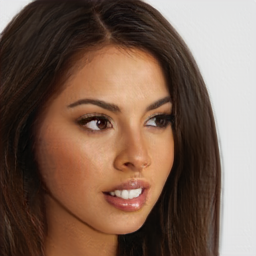

In [11]:
%%time
solver.predict(source, ref, 'female')

In [12]:
source = Image.open('../assets/representative/celeba_hq/src/female/069067.jpg')
ref = Image.open('../assets/representative/celeba_hq/ref/female/030321.jpg')

CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 71.5 ms


/home/kianboon/miniconda/envs/stargan-v2/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


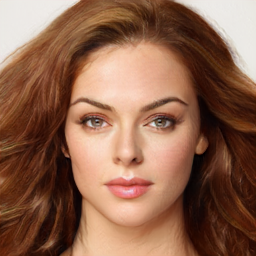

In [14]:
%%time
solver.predict(source, ref, 'female')